In [7]:
"""
Takes results path and plots some observable over time, specified at the bottom of the script.
"""
import os
os.environ["JAX_PLATFORMS"] = "cpu"

import matplotlib.pyplot as plt
import json
import dotenv
from pathlib import Path
import pandas as pd
import numpy as np

In [8]:
root_path = '/net/vast-storage/scratch/vast/mcdermott/rphess/modula-v2/'
path = Path(root_path) / "experiment/results/"
sub_folders = ['hardcap_results', 'orthog_results', 'softcap_results', 'spec_normalize_results', 'spec_wd_results', 'specham_results']

results_concatenated = []
# iterate over all subfolders and open all json files in them
for sub_folder in sub_folders:
    sub_folder_path = path / sub_folder
    for json_file in sub_folder_path.glob('*.json'):
        with open(json_file, 'r') as f:
            data = json.load(f)
            # add the data to the results list
            results = data['results']
            technique = data['parameters']['project']['default']
            lr = data['parameters']['lr']
            wmax = data['parameters']['w_max']
            best_train_loss = min(results['losses'])
            best_val_loss = min(results['val_losses'])
            best_train_acc = max(results['train_accuracies'])
            best_val_acc = max(results['accuracies'])
            row = {
                'technique': technique,
                'lr': lr,
                'w_max': wmax,
                'best_train_loss': best_train_loss,
                'best_val_loss': best_val_loss,
                'best_train_acc': best_train_acc,
                'best_val_acc': best_val_acc
            }
            results_concatenated.append(row)
# create a dataframe from the results
results_df = pd.DataFrame(results_concatenated)

In [9]:
results_df

,technique,lr,w_max,best_train_loss,best_val_loss,best_train_acc,best_val_acc
0,hard_cap,0.001000,1,2.302054,2.302070,0.162109,0.128320
1,hard_cap,0.001585,1,2.301730,2.301756,0.162109,0.123926
2,hard_cap,0.002512,1,2.301177,2.301220,0.162109,0.117871
3,hard_cap,0.003981,1,2.300243,2.300312,0.158203,0.115723
4,hard_cap,0.006310,1,2.298670,2.298794,0.150391,0.115430
...,...,...,...,...,...,...,...
266,spec_hammer,1.584893,1,1.959907,1.955094,0.453125,0.288281
267,spec_hammer,10.000000,1,2.302398,2.302459,0.148438,0.105078
268,spec_hammer,2.511886,1,2.250862,2.220036,0.302734,0.140918
269,spec_hammer,3.981072,1,2.302585,2.293814,0.210938,0.124902


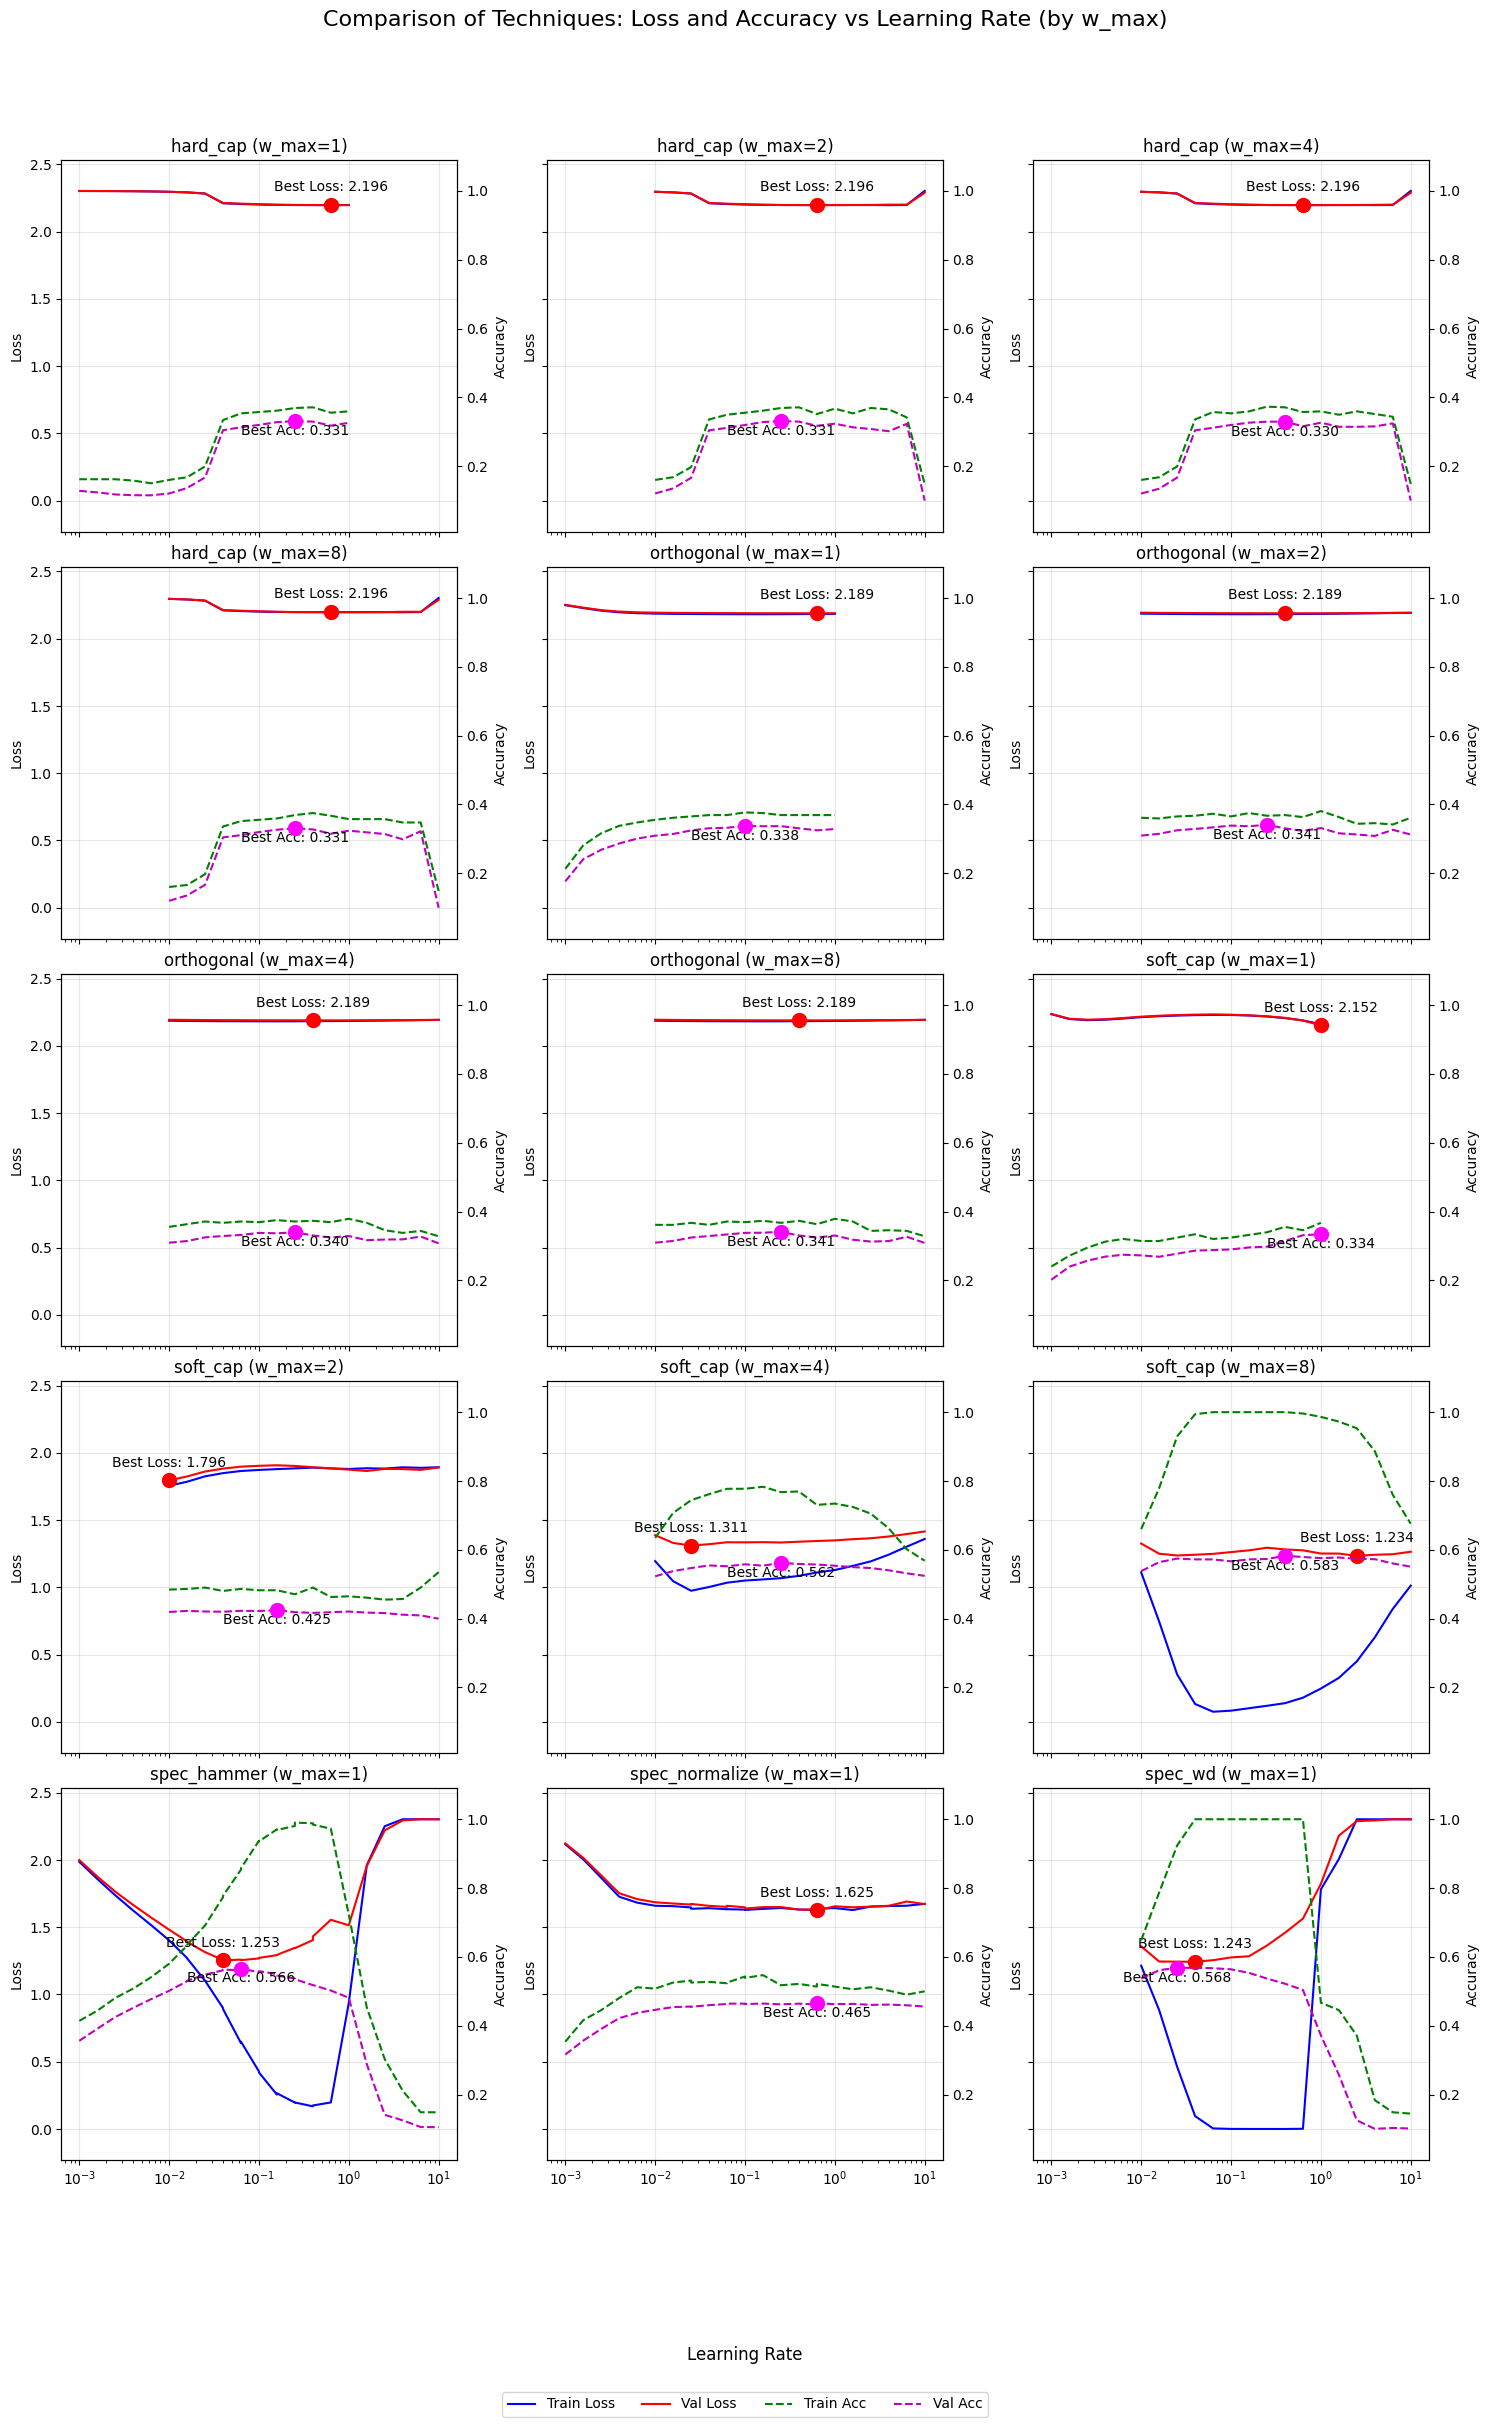

In [13]:
# Group the dataframe by technique and w_max
grouped = results_df.groupby(['technique', 'w_max'])

# Get unique combinations of technique and w_max
technique_wmax_pairs = list(grouped.groups.keys())

# Determine the number of plots needed and create a grid
num_plots = len(technique_wmax_pairs)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

# Create the figure with appropriate size and share both x and y axes
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)
axs = axs.flatten()

# Find global min and max values for losses and accuracies
min_loss = min(results_df['best_train_loss'].min(), results_df['best_val_loss'].min())
max_loss = max(results_df['best_train_loss'].max(), results_df['best_val_loss'].max())
min_acc = min(results_df['best_train_acc'].min(), results_df['best_val_acc'].min())
max_acc = max(results_df['best_train_acc'].max(), results_df['best_val_acc'].max())

# Add some padding to the ranges
loss_range = max_loss - min_loss
acc_range = max_acc - min_acc
loss_padding = loss_range * 0.1
acc_padding = acc_range * 0.1
loss_ylim = (min_loss - loss_padding, max_loss + loss_padding)
acc_ylim = (min_acc - acc_padding, max_acc + acc_padding)

# Loop through each technique and w_max combination
for i, (technique, wmax) in enumerate(technique_wmax_pairs):
    if i >= len(axs):  # Safety check in case there are more pairs than axes
        break
        
    # Filter the dataframe for the technique and w_max
    subset_df = results_df[(results_df['technique'] == technique) & (results_df['w_max'] == wmax)]
    
    # Create a twin axis for accuracies
    ax2 = axs[i].twinx()
    
    # Sort by learning rate for better line plotting
    subset_df = subset_df.sort_values('lr')
    
    # plot the best train and val loss as a function of the learning rate on left axis
    loss_lines1, = axs[i].plot(subset_df['lr'], subset_df['best_train_loss'], 'b-', label='Train Loss')
    loss_lines2, = axs[i].plot(subset_df['lr'], subset_df['best_val_loss'], 'r-', label='Val Loss')
    
    # plot the best train and val accuracy as a function of the learning rate on right axis
    acc_lines1, = ax2.plot(subset_df['lr'], subset_df['best_train_acc'], 'g--', label='Train Acc')
    acc_lines2, = ax2.plot(subset_df['lr'], subset_df['best_val_acc'], 'm--', label='Val Acc')
    
    # Find the point with the best validation loss and mark it
    if not subset_df.empty:
        best_idx = subset_df['best_val_loss'].idxmin()
        best_lr = subset_df.loc[best_idx, 'lr']
        best_val_loss = subset_df.loc[best_idx, 'best_val_loss']
        axs[i].scatter(best_lr, best_val_loss, color='red', s=100, zorder=5)
        axs[i].annotate(f'Best Loss: {best_val_loss:.3f}', 
                       (best_lr, best_val_loss),
                       xytext=(0, 10), 
                       textcoords='offset points',
                       ha='center')
        
        # Find the point with the best validation accuracy and mark it
        best_acc_idx = subset_df['best_val_acc'].idxmax()
        best_acc_lr = subset_df.loc[best_acc_idx, 'lr']
        best_val_acc = subset_df.loc[best_acc_idx, 'best_val_acc']
        ax2.scatter(best_acc_lr, best_val_acc, color='magenta', s=100, zorder=5)
        ax2.annotate(f'Best Acc: {best_val_acc:.3f}', 
                    (best_acc_lr, best_val_acc),
                    xytext=(0, -10), 
                    textcoords='offset points',
                    ha='center')
    
    axs[i].set_title(f'{technique} (w_max={wmax})')
    axs[i].set_xscale('log')
    axs[i].grid(True, alpha=0.3)
    
    # Set labels for the axes
    axs[i].set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    
    # Set the same y-limits for all plots
    axs[i].set_ylim(loss_ylim)
    ax2.set_ylim(acc_ylim)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

# Common x-axis label
fig.text(0.5, 0.04, 'Learning Rate', ha='center', fontsize=12)

# Title for the entire figure
fig.suptitle('Comparison of Techniques: Loss and Accuracy vs Learning Rate (by w_max)', fontsize=16, y=0.98)

# Create a unified legend
lines = [loss_lines1, loss_lines2, acc_lines1, acc_lines2]
labels = ['Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=4)

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.12)  # Increase the top margin to make room for the title
plt.show()


In [27]:
spec_ham_df = results_df[results_df['technique'] == 'spec_hammer']
spec_ham_df = spec_ham_df.sort_values('lr')
spec_ham_df

,technique,lr,w_max,best_train_loss,best_val_loss,best_train_acc,best_val_acc
239,spec_hammer,0.001000,1,1.986796,1.999760,0.414062,0.356055
240,spec_hammer,0.001585,1,1.859091,1.877021,0.443359,0.391016
241,spec_hammer,0.002512,1,1.737876,1.764901,0.480469,0.425000
242,spec_hammer,0.003981,1,1.623804,1.665407,0.507812,0.451758
243,spec_hammer,0.006310,1,1.515475,1.571887,0.541016,0.477344
244,spec_hammer,0.010000,1,1.402766,1.481663,0.580078,0.501367
245,spec_hammer,0.010000,1,1.402766,1.481663,0.580078,0.501367
247,spec_hammer,0.015849,1,1.270746,1.394848,0.632812,0.529297
246,spec_hammer,0.015849,1,1.268878,1.391216,0.634766,0.530762
248,spec_hammer,0.025119,1,1.102344,1.314612,0.691406,0.548438
